In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4,5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=1):
    channel_size = 128
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        512       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 128)        512       
_________________________________________________________________
activation (Activation)      (None, 16000, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 128)        49280     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 128)        512       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 128)        512       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 128)        49280     
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 128)        49280     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 128)        512       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 128)        49280     
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 128)        49280     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 128)        512       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 128)        49280     
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 128)        49280     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1975 - acc: 0.3784
Epoch 00001: val_loss improved from inf to 1.40801, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_4_conv_checkpoint/001-1.4080.hdf5
36805/36805 [==============================] - 293s 8ms/sample - loss: 2.1974 - acc: 0.3784 - val_loss: 1.4080 - val_acc: 0.5712
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3399 - acc: 0.5916
Epoch 00002: val_loss improved from 1.40801 to 1.09588, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_4_conv_checkpoint/002-1.0959.hdf5
36805/36805 [==============================] - 286s 8ms/sample - loss: 1.3400 - acc: 0.5916 - val_loss: 1.0959 - val_acc: 0.6765
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0848 - acc: 0.6701
Epoch 00003: val_loss improved from 1.0

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1259 - acc: 0.9598
Epoch 00027: val_loss did not improve from 0.87290
36805/36805 [==============================] - 288s 8ms/sample - loss: 0.1260 - acc: 0.9597 - val_loss: 1.1688 - val_acc: 0.7636
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1276 - acc: 0.9600
Epoch 00028: val_loss did not improve from 0.87290
36805/36805 [==============================] - 289s 8ms/sample - loss: 0.1276 - acc: 0.9600 - val_loss: 1.0910 - val_acc: 0.7841
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1257 - acc: 0.9604
Epoch 00029: val_loss did not improve from 0.87290
36805/36805 [==============================] - 290s 8ms/sample - loss: 0.1259 - acc: 0.9604 - val_loss: 1.1379 - val_acc: 0.7815
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1165 - acc: 0.9624
Epoch 00030: val_loss did not improve from 0.87290
36805/36805 [========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0604 - acc: 0.9826
Epoch 00057: val_loss did not improve from 0.87290
36805/36805 [==============================] - 287s 8ms/sample - loss: 0.0604 - acc: 0.9826 - val_loss: 1.2493 - val_acc: 0.7880
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0615 - acc: 0.9823
Epoch 00058: val_loss did not improve from 0.87290
36805/36805 [==============================] - 289s 8ms/sample - loss: 0.0615 - acc: 0.9823 - val_loss: 1.2171 - val_acc: 0.7941
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0725 - acc: 0.9789
Epoch 00059: val_loss did not improve from 0.87290
36805/36805 [==============================] - 288s 8ms/sample - loss: 0.0727 - acc: 0.9788 - val_loss: 1.1580 - val_acc: 0.7901
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0640 - acc: 0.9809
Epoch 00060: val_loss did not improve from 0.87290
36805/36805 [========

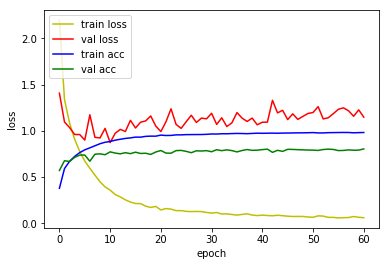

4815/4815 [==============================] - 16s 3ms/sample - loss: 0.9776 - acc: 0.7290
Loss: 0.977601520146165 Accuracy: 0.72897196

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0281 - acc: 0.4079
Epoch 00001: val_loss improved from inf to 1.46546, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_5_conv_checkpoint/001-1.4655.hdf5
36805/36805 [==============================] - 307s 8ms/sample - loss: 2.0281 - acc: 0.4079 - val_loss: 1.4655 - val_acc: 0.5630
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1921 - acc: 0.6388
Epoch 00002: val_loss improved from 1.46546 to 0.97696, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_5_conv_checkpoint/002-0.9770.hdf5
36805/36805 [==============================] - 300s 8ms/sample - loss: 1.1924 - acc: 0.6388 - val_loss: 0.9770 - val_acc: 0.7018
Epoch 3/500
36800/36805 [=======================

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1312 - acc: 0.9576
Epoch 00028: val_loss did not improve from 0.59768
36805/36805 [==============================] - 300s 8ms/sample - loss: 0.1313 - acc: 0.9576 - val_loss: 0.7071 - val_acc: 0.8477
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1297 - acc: 0.9598
Epoch 00029: val_loss did not improve from 0.59768
36805/36805 [==============================] - 300s 8ms/sample - loss: 0.1298 - acc: 0.9598 - val_loss: 0.7322 - val_acc: 0.8493
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1274 - acc: 0.9584
Epoch 00030: val_loss did not improve from 0.59768
36805/36805 [==============================] - 300s 8ms/sample - loss: 0.1276 - acc: 0.9584 - val_loss: 0.7108 - val_acc: 0.8509
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1287 - acc: 0.9590
Epoch 00031: val_loss did not improve from 0.59768
36805/36805 [========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0560 - acc: 0.9827
Epoch 00058: val_loss did not improve from 0.59768
36805/36805 [==============================] - 300s 8ms/sample - loss: 0.0560 - acc: 0.9827 - val_loss: 0.8125 - val_acc: 0.8567
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0633 - acc: 0.9804
Epoch 00059: val_loss did not improve from 0.59768
36805/36805 [==============================] - 301s 8ms/sample - loss: 0.0633 - acc: 0.9804 - val_loss: 0.8515 - val_acc: 0.8512
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0609 - acc: 0.9812
Epoch 00060: val_loss did not improve from 0.59768
36805/36805 [==============================] - 301s 8ms/sample - loss: 0.0609 - acc: 0.9813 - val_loss: 0.7796 - val_acc: 0.8635
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0632 - acc: 0.9808
Epoch 00061: val_loss did not improve from 0.59768
36805/36805 [========

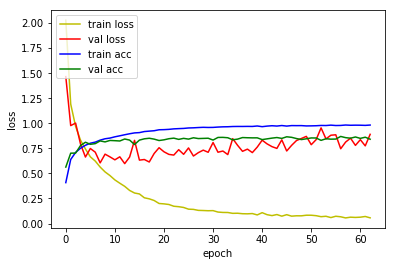

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.6927 - acc: 0.8135
Loss: 0.6927284018520502 Accuracy: 0.8134995

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9785 - acc: 0.4026
Epoch 00001: val_loss improved from inf to 1.25330, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_6_conv_checkpoint/001-1.2533.hdf5
36805/36805 [==============================] - 316s 9ms/sample - loss: 1.9784 - acc: 0.4027 - val_loss: 1.2533 - val_acc: 0.6000
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1228 - acc: 0.6543
Epoch 00002: val_loss improved from 1.25330 to 0.84973, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_6_conv_checkpoint/002-0.8497.hdf5
36805/36805 [==============================] - 306s 8ms/sample - loss: 1.1230 - acc: 0.6542 - val_loss: 0.8497 - val_acc: 0.7414
Epoch 3/500
36800/36805 [=======================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1242 - acc: 0.9601
Epoch 00026: val_loss improved from 0.36238 to 0.35368, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_6_conv_checkpoint/026-0.3537.hdf5
36805/36805 [==============================] - 306s 8ms/sample - loss: 0.1246 - acc: 0.9601 - val_loss: 0.3537 - val_acc: 0.9196
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1227 - acc: 0.9601
Epoch 00027: val_loss did not improve from 0.35368
36805/36805 [==============================] - 305s 8ms/sample - loss: 0.1228 - acc: 0.9601 - val_loss: 0.3930 - val_acc: 0.9068
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1113 - acc: 0.9638
Epoch 00028: val_loss did not improve from 0.35368
36805/36805 [==============================] - 306s 8ms/sample - loss: 0.1114 - acc: 0.9638 - val_loss: 0.4073 - val_acc: 0.9066
Epoch 29/500
36800/36805 [============================>.] -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0429 - acc: 0.9865
Epoch 00055: val_loss did not improve from 0.35368
36805/36805 [==============================] - 307s 8ms/sample - loss: 0.0429 - acc: 0.9865 - val_loss: 0.3827 - val_acc: 0.9227
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0449 - acc: 0.9858
Epoch 00056: val_loss did not improve from 0.35368
36805/36805 [==============================] - 307s 8ms/sample - loss: 0.0448 - acc: 0.9858 - val_loss: 0.3682 - val_acc: 0.9315
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0456 - acc: 0.9861
Epoch 00057: val_loss did not improve from 0.35368
36805/36805 [==============================] - 307s 8ms/sample - loss: 0.0456 - acc: 0.9861 - val_loss: 0.4022 - val_acc: 0.9271
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.9850
Epoch 00058: val_loss did not improve from 0.35368
36805/36805 [=====================

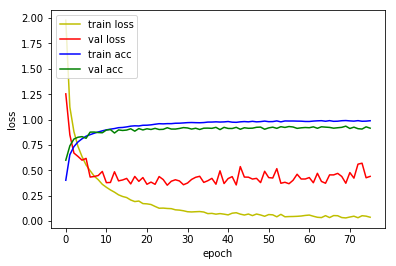

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.4132 - acc: 0.8966
Loss: 0.41316051120760533 Accuracy: 0.8965732

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1789 - acc: 0.3439
Epoch 00001: val_loss improved from inf to 1.17821, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_7_conv_checkpoint/001-1.1782.hdf5
36805/36805 [==============================] - 324s 9ms/sample - loss: 2.1789 - acc: 0.3439 - val_loss: 1.1782 - val_acc: 0.6408
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1559 - acc: 0.6392
Epoch 00002: val_loss improved from 1.17821 to 0.72384, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_7_conv_checkpoint/002-0.7238.hdf5
36805/36805 [==============================] - 310s 8ms/sample - loss: 1.1561 - acc: 0.6391 - val_loss: 0.7238 - val_acc: 0.7936
Epoch 3/500
36800/36805 [======================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0854 - acc: 0.9718
Epoch 00025: val_loss did not improve from 0.19277
36805/36805 [==============================] - 311s 8ms/sample - loss: 0.0854 - acc: 0.9717 - val_loss: 0.2021 - val_acc: 0.9469
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0798 - acc: 0.9735
Epoch 00026: val_loss did not improve from 0.19277
36805/36805 [==============================] - 311s 8ms/sample - loss: 0.0799 - acc: 0.9734 - val_loss: 0.2988 - val_acc: 0.9329
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0762 - acc: 0.9739
Epoch 00027: val_loss did not improve from 0.19277
36805/36805 [==============================] - 311s 8ms/sample - loss: 0.0762 - acc: 0.9739 - val_loss: 0.2341 - val_acc: 0.9453
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0670 - acc: 0.9786
Epoch 00028: val_loss did not improve from 0.19277
36805/36805 [=====================

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.9899
Epoch 00054: val_loss did not improve from 0.18875
36805/36805 [==============================] - 311s 8ms/sample - loss: 0.0297 - acc: 0.9899 - val_loss: 0.2195 - val_acc: 0.9546
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9915
Epoch 00055: val_loss did not improve from 0.18875
36805/36805 [==============================] - 310s 8ms/sample - loss: 0.0255 - acc: 0.9915 - val_loss: 0.2173 - val_acc: 0.9534
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0346 - acc: 0.9884
Epoch 00056: val_loss did not improve from 0.18875
36805/36805 [==============================] - 311s 8ms/sample - loss: 0.0346 - acc: 0.9884 - val_loss: 0.2144 - val_acc: 0.9569
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0195 - acc: 0.9940
Epoch 00057: val_loss did not improve from 0.18875
36805/36805 [========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0134 - acc: 0.9958
Epoch 00084: val_loss did not improve from 0.18875
36805/36805 [==============================] - 311s 8ms/sample - loss: 0.0142 - acc: 0.9958 - val_loss: 0.2284 - val_acc: 0.9581
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0244 - acc: 0.9916
Epoch 00085: val_loss did not improve from 0.18875
36805/36805 [==============================] - 311s 8ms/sample - loss: 0.0245 - acc: 0.9916 - val_loss: 0.2210 - val_acc: 0.9569
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9938
Epoch 00086: val_loss did not improve from 0.18875
36805/36805 [==============================] - 311s 8ms/sample - loss: 0.0191 - acc: 0.9938 - val_loss: 0.2043 - val_acc: 0.9602
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9970
Epoch 00087: val_loss did not improve from 0.18875
36805/36805 [========

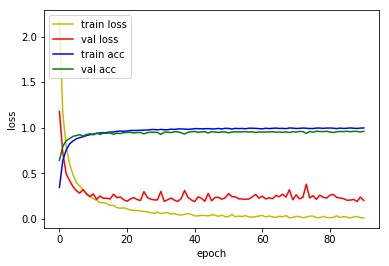

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.1987 - acc: 0.9533
Loss: 0.1986725314780451 Accuracy: 0.95327103

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1175 - acc: 0.3725
Epoch 00001: val_loss improved from inf to 0.93022, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_8_conv_checkpoint/001-0.9302.hdf5
36805/36805 [==============================] - 331s 9ms/sample - loss: 2.1176 - acc: 0.3726 - val_loss: 0.9302 - val_acc: 0.7258
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9354 - acc: 0.7089
Epoch 00002: val_loss improved from 0.93022 to 0.57737, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_8_conv_checkpoint/002-0.5774.hdf5
36805/36805 [==============================] - 312s 8ms/sample - loss: 0.9353 - acc: 0.7090 - val_loss: 0.5774 - val_acc: 0.8246
Epoch 3/500
36800/36805 [======================

36805/36805 [==============================] - 314s 9ms/sample - loss: 0.0654 - acc: 0.9796 - val_loss: 0.1128 - val_acc: 0.9688
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0550 - acc: 0.9829
Epoch 00025: val_loss did not improve from 0.11285
36805/36805 [==============================] - 313s 9ms/sample - loss: 0.0550 - acc: 0.9829 - val_loss: 0.1619 - val_acc: 0.9576
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0543 - acc: 0.9832
Epoch 00026: val_loss did not improve from 0.11285
36805/36805 [==============================] - 313s 9ms/sample - loss: 0.0543 - acc: 0.9832 - val_loss: 0.1288 - val_acc: 0.9632
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0599 - acc: 0.9802
Epoch 00027: val_loss did not improve from 0.11285
36805/36805 [==============================] - 313s 9ms/sample - loss: 0.0599 - acc: 0.9802 - val_loss: 0.1260 - val_acc: 0.9690
Epoch 28/500
36800/36805 [==============

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0309 - acc: 0.9904
Epoch 00054: val_loss improved from 0.11273 to 0.10471, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_8_conv_checkpoint/054-0.1047.hdf5
36805/36805 [==============================] - 314s 9ms/sample - loss: 0.0309 - acc: 0.9904 - val_loss: 0.1047 - val_acc: 0.9704
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0159 - acc: 0.9956
Epoch 00055: val_loss did not improve from 0.10471
36805/36805 [==============================] - 313s 9ms/sample - loss: 0.0164 - acc: 0.9955 - val_loss: 0.1487 - val_acc: 0.9662
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0260 - acc: 0.9915
Epoch 00056: val_loss did not improve from 0.10471
36805/36805 [==============================] - 314s 9ms/sample - loss: 0.0260 - acc: 0.9915 - val_loss: 0.1223 - val_acc: 0.9676
Epoch 57/500
36800/36805 [============================>.] -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0190 - acc: 0.9942
Epoch 00083: val_loss did not improve from 0.10471
36805/36805 [==============================] - 314s 9ms/sample - loss: 0.0191 - acc: 0.9941 - val_loss: 0.1475 - val_acc: 0.9676
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0146 - acc: 0.9951
Epoch 00084: val_loss did not improve from 0.10471
36805/36805 [==============================] - 314s 9ms/sample - loss: 0.0147 - acc: 0.9951 - val_loss: 0.1430 - val_acc: 0.9697
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0172 - acc: 0.9951
Epoch 00085: val_loss did not improve from 0.10471
36805/36805 [==============================] - 314s 9ms/sample - loss: 0.0173 - acc: 0.9951 - val_loss: 0.1459 - val_acc: 0.9709
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0118 - acc: 0.9967
Epoch 00086: val_loss did not improve from 0.10471
36805/36805 [=====================

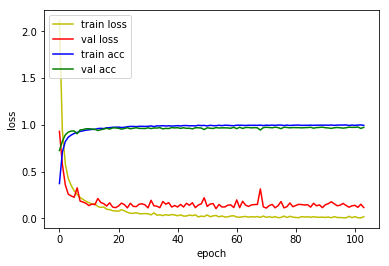

4815/4815 [==============================] - 19s 4ms/sample - loss: 0.1302 - acc: 0.9639
Loss: 0.13020230604235086 Accuracy: 0.96386296

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6270 - acc: 0.5272
Epoch 00001: val_loss improved from inf to 0.63462, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_9_conv_checkpoint/001-0.6346.hdf5
36805/36805 [==============================] - 331s 9ms/sample - loss: 1.6271 - acc: 0.5272 - val_loss: 0.6346 - val_acc: 0.8015
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5880 - acc: 0.8170
Epoch 00002: val_loss improved from 0.63462 to 0.28073, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_9_conv_checkpoint/002-0.2807.hdf5
36805/36805 [==============================] - 311s 8ms/sample - loss: 0.5881 - acc: 0.8169 - val_loss: 0.2807 - val_acc: 0.9180
Epoch 3/500
36800/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9879
Epoch 00025: val_loss did not improve from 0.10793
36805/36805 [==============================] - 312s 8ms/sample - loss: 0.0385 - acc: 0.9879 - val_loss: 0.1547 - val_acc: 0.9590
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0489 - acc: 0.9844
Epoch 00026: val_loss improved from 0.10793 to 0.09911, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_9_conv_checkpoint/026-0.0991.hdf5
36805/36805 [==============================] - 311s 8ms/sample - loss: 0.0491 - acc: 0.9844 - val_loss: 0.0991 - val_acc: 0.9727
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0492 - acc: 0.9849
Epoch 00027: val_loss did not improve from 0.09911
36805/36805 [==============================] - 312s 8ms/sample - loss: 0.0492 - acc: 0.9849 - val_loss: 0.1341 - val_acc: 0.9662
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - lo

36800/36805 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9906
Epoch 00054: val_loss did not improve from 0.09911
36805/36805 [==============================] - 311s 8ms/sample - loss: 0.0299 - acc: 0.9906 - val_loss: 0.1414 - val_acc: 0.9651
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0125 - acc: 0.9960
Epoch 00055: val_loss did not improve from 0.09911
36805/36805 [==============================] - 311s 8ms/sample - loss: 0.0126 - acc: 0.9960 - val_loss: 0.1269 - val_acc: 0.9725
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0117 - acc: 0.9965
Epoch 00056: val_loss did not improve from 0.09911
36805/36805 [==============================] - 311s 8ms/sample - loss: 0.0117 - acc: 0.9965 - val_loss: 0.1231 - val_acc: 0.9695
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9971
Epoch 00057: val_loss did not improve from 0.09911
36805/36805 [=====================

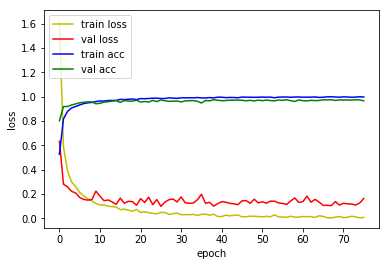

4815/4815 [==============================] - 20s 4ms/sample - loss: 0.1419 - acc: 0.9607
Loss: 0.1418630836651441 Accuracy: 0.96074766



In [10]:
base = '1D_CNN_custom_conv_3_VGG_ch_128_DO_BN'

for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
        
    model = multi_gpu_model(model, gpus=2)
    
    #         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_ch_128_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_4_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_90_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 16)           1562000     lambda[0][0]                     
                                                         

4815/4815 [==============================] - 20s 4ms/sample - loss: 0.1302 - acc: 0.9639
Loss: 0.13020230604235086 Accuracy: 0.96386296

1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_9_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_150_input (InputLayer)   (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_150_input[0][0]           
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_150_input[0][0]           
__________________________________________________________________________________________________
sequential_14 (Seque

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_4_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_90_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_90_input[0][0]            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 16)           1562000     lambda[0][0]                     
                                                         

4815/4815 [==============================] - 21s 4ms/sample - loss: 0.1493 - acc: 0.9672
Loss: 0.14931701532588812 Accuracy: 0.96718585

1D_CNN_custom_conv_3_VGG_ch_128_DO_BN_9_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_150_input (InputLayer)   (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_150_input[0][0]           
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_150_input[0][0]           
__________________________________________________________________________________________________
sequential_14 (Seque